## Preambule

In [1]:
import numpy as np
import pandas as pd
import yaml
import xarray as xr
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import math

## Parameters

In [2]:
filename = 'IMAGE_example.xlsx'
time = 2050
region = 'Europe'

## Read in data

First, we start with the preprocessed ensemble data. We computed this earlier for you, but feel free to have a look a `Reproduce_paper.ipynb` or `class_datahandling` to see how it works.

In [3]:
with open("../Configuration/config.yaml", "r") as stream:
    settings = yaml.load(stream, Loader=yaml.Loader)
integers_touse = [0, 1, 3, 4, 5, 7, 8, 9]
list_of_models = np.array([settings['models'][m]['full_name'] for m in settings['models'].keys()])[integers_touse]
list_of_model_shortnames = np.array([settings['models'][m]['short_name'] for m in settings['models'].keys()])[integers_touse]
list_of_colors = np.array([settings['models'][m]['color'] for m in settings['models'].keys()])[integers_touse]

In [4]:
data_xr = xr.open_dataset(settings['paths']['data']['handling']+"XRdata.nc")

Now, we read in your dataset. Make sure that it is the same file format as the example we provide (in `Data/Own_model/IMAGE_example.xlsx`).

In [5]:
df = pd.read_excel("../Data/Own_model/"+filename, sheet_name='data')

In [6]:
dummy = df.drop(['Unit', 'Region'], axis=1)
dummy = dummy.melt(id_vars=["Model", "Scenario", "Variable"], var_name="Time", value_name="Value")
dummy['Time'] = dummy.Time.astype(int)
dummy = dummy.set_index(['Model', 'Scenario', 'Variable', 'Time'])
xr_individual = xr.Dataset.from_dataframe(dummy)
xr_individual = xr_individual.reindex(Time = np.arange(1995, 2101))
xr_individual = xr_individual.interpolate_na(dim="Time", method="linear")

Then, we merge your data with the ensemble.

In [7]:
xr_new = xr.merge([data_xr, xr_individual])

## Compute indicators

Now, all diagnostic indicators are computed, but not saved (to avoid overwriting the existing indicator dataset). Of course, feel free to save it anyway, using something like `calculator.ind_xr.to_netcdf(<path> + "MyIndicators.nc")`, where `<path>` is the directory you want to save it to.

In [8]:
from class_indicatorcalculation import IndicatorCalculation

In [9]:
calculator = IndicatorCalculation(xr_new, extra_mod=[np.array(df.Model)[0]])
calculator.calculate_responsiveness_indicators()
calculator.calculate_mitigationstrategy_indicators()
calculator.calculate_energysupply_indicators()
calculator.calculate_energydemand_indicators()
calculator.calculate_costandeffort_indicators()
calculator.convert_to_indicator_xr()

/storage/qbo/cm-group/src/github/IAMfingerprints/Calculations/class_indicatorcalculation.py:106: RuntimeWarning: All-NaN slice encountered
  potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i], axis=1)
/storage/qbo/cm-group/src/github/IAMfingerprints/Calculations/class_indicatorcalculation.py:106: RuntimeWarning: All-NaN slice encountered
  potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i], axis=1)
/storage/qbo/cm-group/src/github/IAMfingerprints/Calculations/class_indicatorcalculation.py:106: RuntimeWarning: All-NaN slice encountered
  potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i], axis=1)
/storage/qbo/cm-group/src/github/IAMfingerprints/Calculations/class_indicatorcalculation.py:106: RuntimeWarning: All-NaN slice encountered
  potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i], axis=1)
/storage/qbo/cm-group/src/github/IAMfingerprints/Calculations/class_indicatorcalculation.py:106: RuntimeWarning: All-NaN slice encountered
  potentials[s_i, m_i] = np.nanmax(speed[s_i, m_i], axis=1)
/stor

## Plot fingerprint w.r.t. existing ensemble

Note that the example dataset we provided for this exercise only contained a single IMAGE scenario (DIAG-C400-lin). If you provide more scenarios of your own, you will see a scenario range in the figure below, rather than a single line for each indicator - similar to the paper. Also note that one needs to provide a DIAG-NPI scenario in order to compute the R1 indicator, and multiple scenarios to compute R4 and R5, which are therefore not computed for this example.

### Definitions

In [10]:
names =[[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$"],
        [r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$"],
        [r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$"],
        [r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$"],
        [r"$C_1$", "", r"$C_2$", r"$C_3$"]]

namesfull = [["Relative abatement index", "Time scale of initial mitigation", "Maximum mitigation speed", "Sensitivity primary energy mix", "Sensitivity demand"],
            ["Carbon intensity reduction", "Energy intensity reduction", "Carbon capture", r"Role of non-CO$_2$"+" abatement"],
            ["Coal", "Oil", "Gas", "Solar", "Wind", "Biomass", "Nuclear"],
            ["Electricity in transport", "Electricity in industry", "Electricity in buildings", "Electricity emissions", "Hydrogen use"],
            ["Cumulative costs\nper abatement value", "", "Transformation index", "Demand shifts"]]

Cats = ["Responsiveness", "Mitigation strategies", "Energy supply", "Energy demand", "Costs and effort"]

### Helper functions

In [11]:
def point(angle, value):
    unit_x = 0.5*np.cos((90-angle)/360*np.pi*2)
    unit_y = 0.5*np.sin((90-angle)/360*np.pi*2)
    return (unit_x*value+0.5, unit_y*value+0.5)

def point_ex(angle, value, dx):
    unit_x = 0.5*np.cos((90-angle)/360*np.pi*2)
    unit_y = 0.5*np.sin((90-angle)/360*np.pi*2)
    p = (unit_x*value+0.5, unit_y*value+0.5)
    pa = (p[0]+dx*(-unit_y), p[1]+dx*(unit_x))
    pb = (p[0]+dx*(unit_y), p[1]+dx*(-unit_x))
    return p, pa, pb

In [12]:
class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used


In [13]:
def plot_model_passport(ax, model, XRfile, fontfactor=1, enum=-1):
        circle_border = plt.Circle((0.5, 0.5), 0.4, facecolor='white', edgecolor='k', lw=15)
        circle_average = plt.Circle((0.5, 0.5), 0.2, facecolor='white', edgecolor='k', lw=5)
        dr = 3
        vars = [["R1_rai", "R2_time", "R3_speedmax", "R4_sensprim", "R5_sensdem"],
                ["M1_cir", "M2_eir", "M3_cc", "M4_nonco2"],
                ["ES1_coal", "ES2_oil", "ES3_gas", "ES4_solar", "ES5_wind", "ES6_biomass", "ES7_nuclear"],
                ["ED1_etrans", "ED2_eindus", "ED3_ebuild", "ED4_emise", "ED5_hydrogen"],
                ["C1_cost", "C2_ti", "C3_dem"]
                ]
        names = [["Relative abatement index", "Time scale of initial mitigation", "Maximum mitigation speed", "Sensitivity primary energy mix", "Sensitivity demand"],
                ["Carbon intensity reduction", "Energy intensity reduction", "Carbon capture", r"Role of non-CO$_2$"+"abatement"],
                ["Coal", "Oil", "Gas", "Solar", "Wind", "Biomass", "Nuclear"],
                ["Electricity\nin transport", "Electricity\nin industry", "Electricity\nin buildings", "Electricity emissions", "Hydrogen use"],
                ["Cumulative costs per abatement value", "Transformation index", "Demand shifts"]]
        names2 = [[r"$R_1$", r"$R_2$", r"$R_3$", r"$R_4$", r"$R_5$"],
                [r"$M_1$", r"$M_2$", r"$M_3$", r"$M_4$"],
                [r"$Es_1$", r"$Es_2$", r"$Es_3$", r"$Es_4$", r"$Es_5$", r"$Es_6$", r"$Es_7$"],
                [r"$Ed_1$", r"$Ed_2$", r"$Ed_3$",r"$Ed_4$", r"$Ed_5$"],
                [r"$C_1$", r"$C_2$", r"$C_3$"]]
        cols = ['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet']
        incr = 360/len(vars)
        da = (90 - 360/len(vars))
        arc_outer_1 = patches.Arc((0.5, 0.5), 1, 1, theta1=da+0+dr, theta2=da+incr-dr, color=cols[0], lw=10)
        arc_outer_5 = patches.Arc((0.5, 0.5), 1, 1, theta1=da+incr*4+dr, theta2=da+incr*5-dr, color=cols[1], lw=10)
        arc_outer_4 = patches.Arc((0.5, 0.5), 1, 1, theta1=da+incr*3+dr, theta2=da+incr*4-dr, color=cols[2], lw=10)
        arc_outer_3 = patches.Arc((0.5, 0.5), 1, 1, theta1=da+incr*2+dr, theta2=da+incr*3-dr, color=cols[3], lw=10)
        arc_outer_2 = patches.Arc((0.5, 0.5), 1, 1, theta1=da+incr+dr, theta2=da+incr*2-dr, color=cols[4], lw=10)

        ax.add_patch(circle_border)
        ax.add_patch(circle_average)
        ax.add_patch(arc_outer_1)
        ax.add_patch(arc_outer_2)
        ax.add_patch(arc_outer_3)
        ax.add_patch(arc_outer_4)
        ax.add_patch(arc_outer_5)
        ax.plot([0.5], [0.5], 'ko', ms=15, zorder=1e99)

        # Actual data
        time = 2050
        for vl_i, vl in enumerate(vars):
                for var_i, var in enumerate(vl):
                        pas = []
                        pbs = []
                        vals = []
                        for scen in settings['scenarios_c400']:
                                angle = (360/len(vars))*vl_i+((360/len(vars))/(len(vl)+1))*(var_i+1)
                                data = np.array(XRfile.sel(Indicator=var, Scenario=settings['scenarios_c400'], Model=list_of_models).Value)
                                data[data == 0] = np.nan
                                
                                median = np.nanmedian(data)
                                std = np.nanstd(data)
                                min = median - 2*std
                                max = median + 2*std
                                valraw = float(XRfile.sel(Indicator=var, Scenario=scen, Model=model).Value)
                                if valraw != 0:
                                        val = (((valraw - min) / (max - min) - 0.5)*0.8 + 0.4)
                                        val = np.max([0, val])
                                        val = np.min([0.8, val])
                                        p = point(angle, val)
                                        #ax.plot([p[0]], [p[1]], 'o', c=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][vl_i], ms=5, zorder=1e9)

                                        _, pa, pb = point_ex(angle, val, 0.4*val/len(vl))
                                        pas.append(pa)
                                        pbs.append(pb)
                                        vals.append(val)
                                        ax.plot([pa[0], pb[0]], [pa[1], pb[1]], c=cols[vl_i], zorder=1e9, lw=4)

                                if scen == "DIAG-C400-lin":
                                        p0 = point(angle, 0.39*2)
                                        ax.plot([0.5, p0[0]], [0.5, p0[1]], ':', c='silver', zorder=1e9-1)
                                        p0 = point(angle, 0.4*2+0.1)
                                        ax.text(p0[0], p0[1], names2[vl_i][var_i], ha='center', va='center', color=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][vl_i], fontsize=25*fontfactor)
                                        #t1 = plt.Polygon([[0.5, 0.5], pa, pb], color=['forestgreen', 'orange', 'dodgerblue', 'tomato'][vl_i], alpha=0.5)
                                        #ax.add_patch(t1)
                        pas = np.array(pas)
                        pbs = np.array(pbs)
                        vals = np.array(vals)
                        if np.nansum(vals) != 0:
                                w_min = np.where(vals == np.nanmin(vals))[0][0]
                                w_max = np.where(vals == np.nanmax(vals))[0][0]

                                pol = plt.Polygon([pas[w_min], pas[w_max], pbs[w_max], pbs[w_min]], lw=2, color=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][vl_i], alpha=0.5)
                                ax.add_patch(pol)

        ax.text(0.5, 0.52, r'$\eta-2\sigma$', fontsize=20, ha='center', va='center', zorder=1e999)
        ax.text(0.5, 0.72, r'$\eta$', fontsize=20, ha='center', va='center', zorder=1e999)
        ax.text(0.5, 0.92+0.02, r'$\eta+2\sigma$', fontsize=20, ha='center', va='center', zorder=1e999)

        dr = 0.4
        r0 = 0
        for c_i, c in enumerate(Cats):
                ph = [-0.0, 0.17, 1.79, 1.41, 0.41][c_i]*np.pi

                if c_i == 0 or c_i == 4:
                        text = CurvedText(
                        x = 0.54*np.cos(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001)[::-1])+0.5,
                        y = 0.54*np.sin(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001)[::-1])+0.5,
                        text=c,
                        color=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][c_i],
                        fontsize=30*fontfactor,
                        ha='center',
                        va = 'center',
                        axes = ax,
                        )
                if c_i == 1 or c_i == 2 or c_i == 3:
                        text = CurvedText(
                        x = 0.54*np.cos(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001))+0.5,
                        y = 0.54*np.sin(np.arange(r0*np.pi-dr*np.pi+ph, r0*np.pi+dr*np.pi+ph, 0.001))+0.5,
                        text=c,
                        color=['forestgreen', 'orange', 'dodgerblue', 'tomato', 'violet'][c_i],
                        fontsize=30*fontfactor,
                        ha='center',
                        va = 'center',
                        axes = ax,
                        )
        
        if enum >= 0:
                ax.text(0.03, 0.97, ["(a)", "(b)", "(c)", "(d)"][enum], ha='left', va='top', transform = ax.transAxes, fontsize=30*fontfactor)

        # Other
        if model == "MESSAGEix-GLOBIOM 1.2": model = "MESSAGEix-GLOBIOM 1.1"
        if model == "IMAGE 3.2": model = "IMAGE 3.3"
        ax.text(0.5, 1.06, model, fontsize=35*fontfactor, ha='center', va='center', weight='bold')
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

### Actual plotting

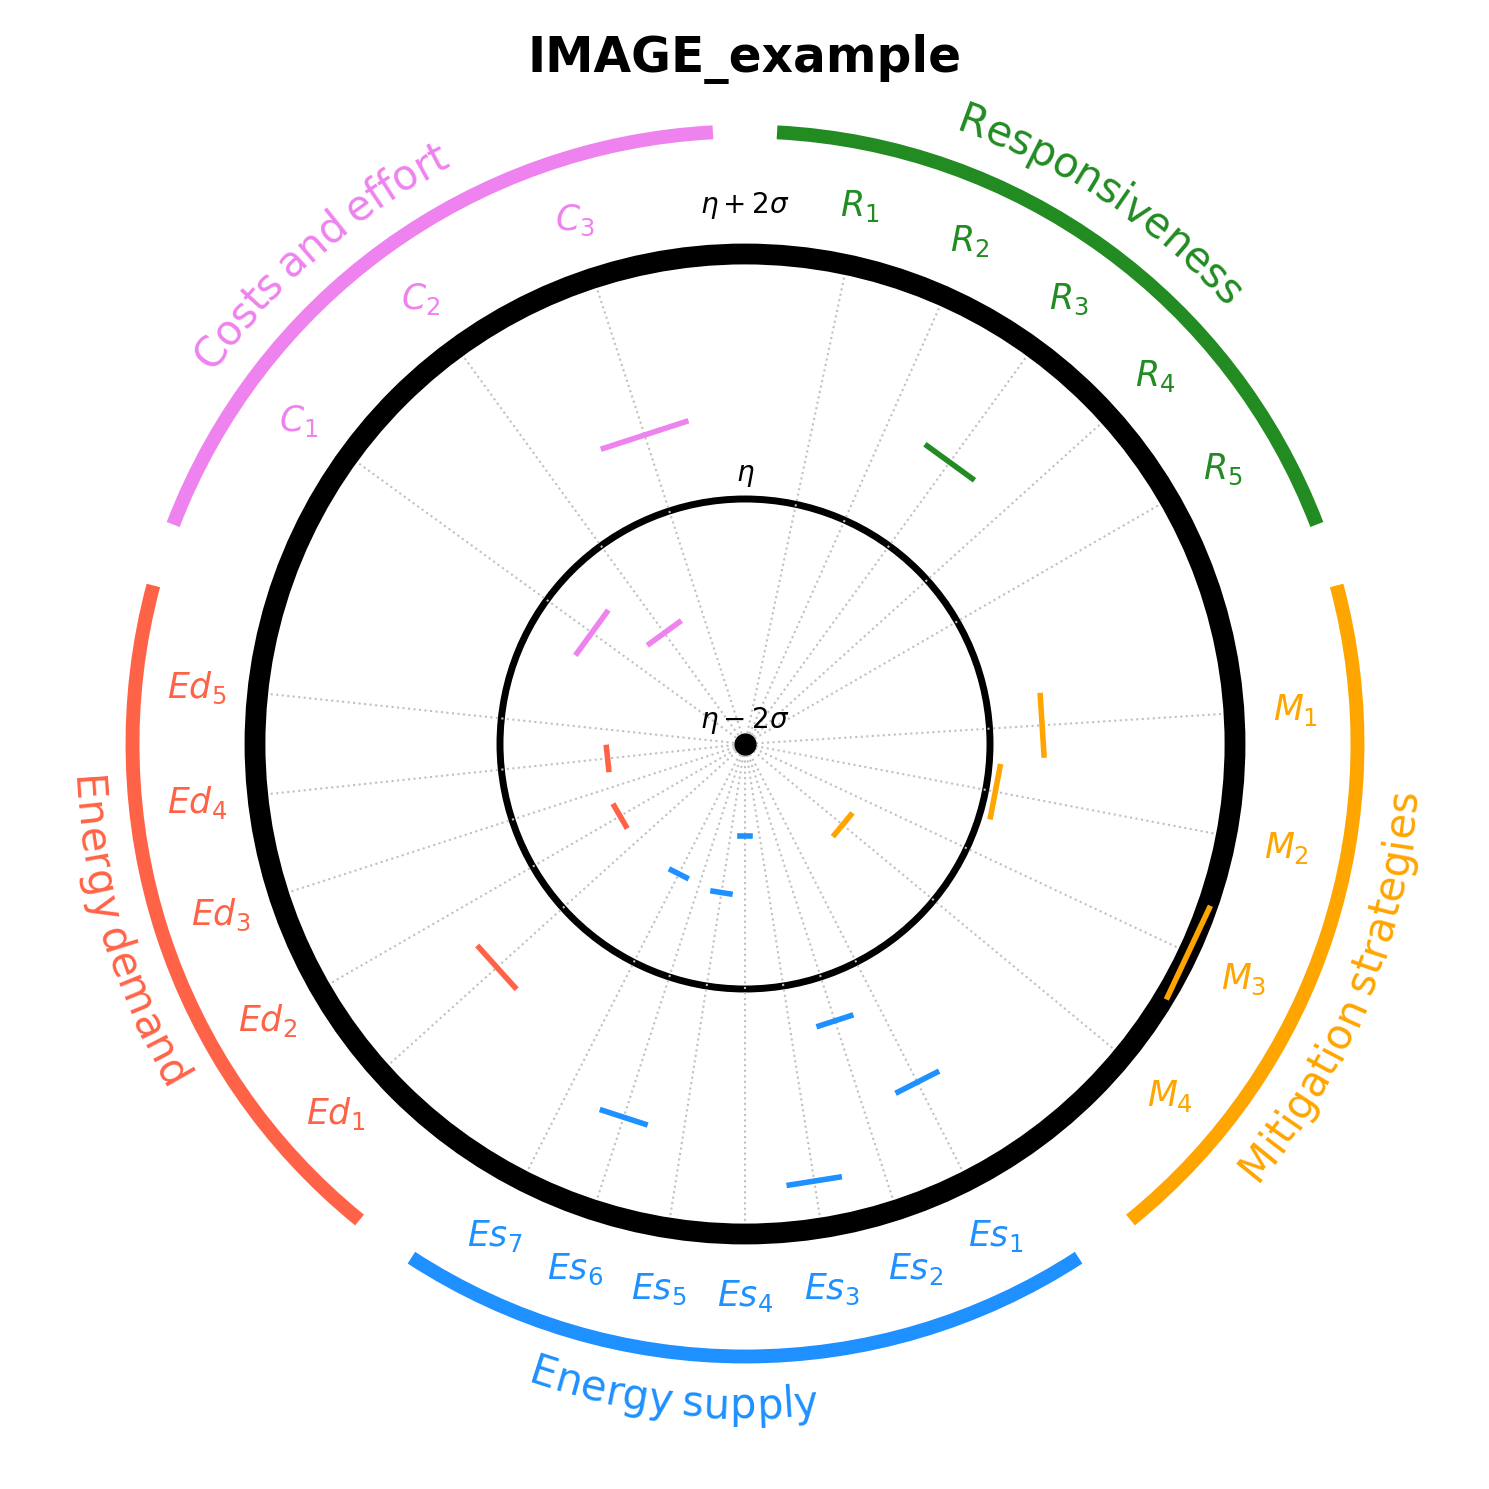

In [14]:
list_of_models = np.array([settings['models'][m]['full_name'] for m in settings['models'].keys()])[integers_touse]
list_of_models = list(list_of_models)+[np.array(df.Model)[0]]
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_model_passport(ax, np.array(df.Model)[0], calculator.ind_xr.sel(Model=list_of_models, Region=region, Scenario=settings['scenarios_c400'], Time=time))
plt.tight_layout()